# Objective

1. Zones' Connectivity



In [1]:
import pandas as pd

import folium

import geopandas as gp

import numpy as np



from scipy.spatial import ConvexHull

import random

from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt

import networkx as nx

import math

# from osgeo import ogr

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter


In [2]:
class Polygon_transition(object):
    
    def __init__(self, **kwargs):
        """ Load your trained model and initialize the parameters """
        pass
    
    def Get_PolyCoords(self, Geo_Obj):

        if Geo_Obj.type=='Polygon':

            return list(Geo_Obj.exterior.coords)

        elif Geo_Obj.type=='MultiPolygon':
            
            boundary=list()
            
            for polygon in Geo_Obj:
                
                boundary+=list(polygon.exterior.coords)
                
            return boundary
        
    def Get_intersect(self, polygon1,polygon2):
        
        intersect=list(set(polygon1).intersection(set(polygon2)))
        
        if len(intersect)!=0:
            
            return True
        
        else:
            return False

In [3]:
'''Load data'''

'''Zone-related data'''

Taxi_Zones=np.load('./Data/NYC_Zones/Taxi_Zones.npy',allow_pickle=True).item()

Zone_list=np.load('./Data/NYC_Zones/Zone_list.npy',allow_pickle=True)

Zone_Center=np.load('./Data/NYC_Zones/Zone_Center.npy',allow_pickle=True).item()

Zone_Link=np.load('./Data/NYC_Zones/Zone_Link.npy',allow_pickle=True).item()

'''Link-related data'''

Link_geometry=np.load('./Data/NYC_Zones/Link_geometry.npy',allow_pickle=True).item()

'''GeoSeries Object'''

polys = gp.GeoSeries(Taxi_Zones)


In [4]:
PT=Polygon_transition()

Node_size=len(Zone_list)

Connect_matrix=np.ones([Node_size,Node_size])*float('inf')

for i in range(Node_size):
    
    Connect_matrix[i][i]=1.0

    for j in range(1+i,Node_size,1):
        
        boundary=PT.Get_PolyCoords(Taxi_Zones[Zone_list[i]])
        
        next_boundary=PT.Get_PolyCoords(Taxi_Zones[Zone_list[j]])

        if PT.Get_intersect(boundary,next_boundary):
            
            Connect_matrix[i][j]=1.0
            
            Connect_matrix[j][i]=1.0     
            
'''Modify'''

Island_connection={19:[20,21],20:[19,21],21:[2,15],48:[30,52],38:[28,27]}

for k,v in Island_connection.items():
    for h in v:
        
        Connect_matrix[k][h]=1.0
        Connect_matrix[h][k]=1.0
        
np.save('./Data/NYC_Zones/Connect_matrix',Connect_matrix)
        

In [6]:
'''Visualization'''

df=pd.DataFrame(np.array(list(Taxi_Zones.values())),columns=['geometry'])

df=gp.GeoDataFrame(df)

df=df.set_crs(epsg=4326)

'''Background'''

background = folium.Map([40.769602, -73.973667],tiles='openstreetmap',zoom_start=12)

'''Zones'''

folium.Choropleth(
    geo_data=df,
    fill_color='blue',
    fill_opacity=0.1,
    name='Zone').add_to(background)

for zone,coord in Zone_Center.items():
    
    folium.map.Marker(location=coord[::-1],\
                      icon=folium.DivIcon(icon_size=(150,36),\
                                   icon_anchor=(0,0),\
                                   html="""<div style="font-size: 12pt; color:red">"""+zone+"""</div>""")).add_to(background)


folium.LayerControl().add_to(background)

background.save('Zone.html')


background

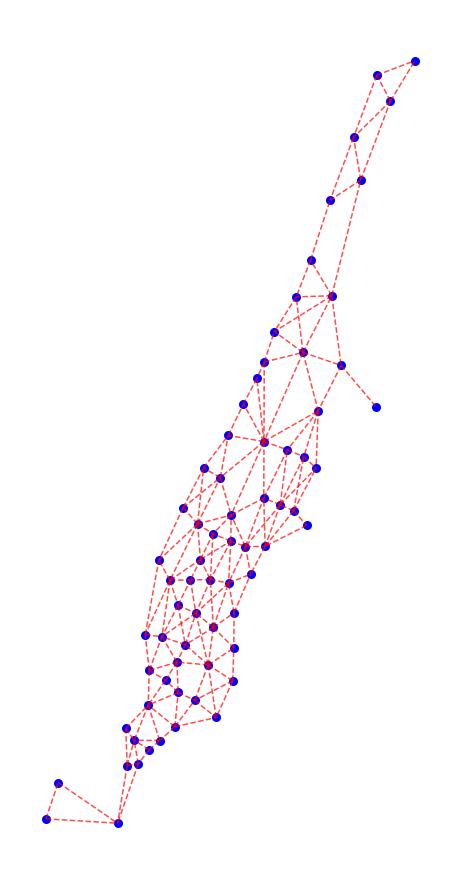

In [18]:
figsize = 8,16

fig,ax = plt.subplots(figsize=figsize)

X=[x[0] for x in Zone_Center.values()]
Y=[x[1] for x in Zone_Center.values()]

ax.scatter(X,Y,c='b',alpha=1,linewidths=3)

for i in range(Node_size):
    
    in_x,in_y=X[i],Y[i]

    for j in range(1+i,Node_size,1):
        
        out_x,out_y=X[j],Y[j]
        
        if Connect_matrix[i][j]==1.0:
            
            ax.plot([in_x,out_x],[in_y,out_y],'r--',alpha=0.7)
        


'''Turn off the axis'''

plt.xticks([])  
plt.yticks([])  
plt.axis('off') 

plt.show()